In [34]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from matplotlib import pyplot as plt

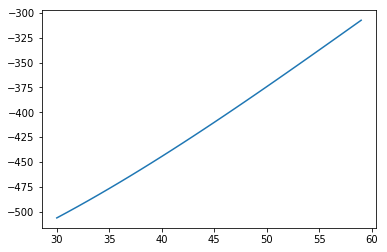

In [67]:
def calc_price(theta1, theta2, mu1, mu2, cost):
    """compute each insurer's price (assumes interior solution)"""
    p1 = (2.*theta1*mu1+theta2*mu2)/3. + cost
    p2 = (2.*theta2*mu2+theta1*mu1)/3. + cost
    return p1, p2
  
    
def calc_t(theta1, theta2, mu1, mu2, cost):
    """compute the proportion of people choosing each insurer"""
    p1,p2 = calc_price(theta1, theta2, mu1, mu2, cost)
    t_hat = .5 + (p2 - p1)/(2.*cost)
    return t_hat


def calc_profits(theta1, theta2, mu1, mu2, cost):
    """compute profits for each firm"""
    p1, p2 = calc_price(theta1, theta2, mu1, mu2, cost)
    t1 = calc_t(theta1, theta2, mu1, mu2, cost)
    return t1*(p1-theta1*mu1)


#arbitrary outside option...
def nash_in_nash(theta1, theta2, mu1, mu2, cost, outside):
    return -1*calc_profits(theta1,theta2,mu1,mu2,cost)*(theta1*mu1+ theta2*mu2 - outside)


plt.plot([i for i in range(30,60)],  [nash_in_nash(i, 60, .5, .5, 10, 0) for i in range(30,60)])

In [36]:
def bargain_helper(theta1, theta2, mu1, mu2, cost, outside):
    """solve each firm 1s optimization holding theta 2 fixed"""
    result = minimize(nash_in_nash, theta1, args=(theta2, mu1, mu2, cost, outside),
                      method='Nelder-Mead', options={'disp': False})
    return result.x


print(bargain_helper(10, 60, .5, .5, 10, 35))

[46.66668701]


In [40]:
def simult_bargain(theta1, theta2, mu1, mu2, cost, outside):
    """solve the bargaining problems seperately and iterate for a solution"""       
    
    #loop variables
    diff =  theta1

    maxiter = 10
    while maxiter >=0 and diff > 10e-7:
        #seems as though there is a contraction mapping here, need to think more about why
        theta1 = bargain_helper(theta1, theta2, mu1, mu2, cost, outside)
        theta2 = bargain_helper(theta2, theta1, mu2, mu1, cost, outside)
        
        #update loop variables
        diff = np.abs(np.max(theta1 - theta2))
        maxiter = maxiter-1
        
    return theta1, theta2


print(simult_bargain(4,4,.5,.5,10,0))

(array([15.00002823]), array([14.9999663]))


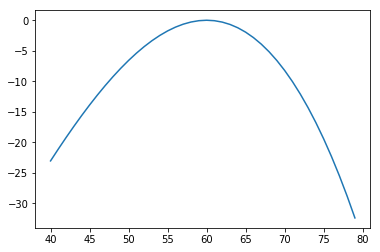

In [74]:
def seq_obj(theta1, mu1, mu2, cost, outside):
    """ theta2 in the second stage """
    #print('yoyo',mu1,mu2,cost,outside)
    theta2 = bargain_helper(theta1, theta1, mu2, mu1, cost, outside)
    return nash_in_nash(theta1, theta2, mu1, mu2, cost, outside)

plt.plot([i for i in range(40,80)],  [seq_obj(i, .5, .5, 10, 0) for i in range(40,80)])

In [75]:
def seq_bargain(theta1, mu1, mu2, cost, outside):
    """solve the bargaining problems seperately,
    then solve for the solution"""   
    #only compute no deal 1x for initial
    result = minimize(seq_obj, theta1, args=(mu1, mu2, cost, outside),
                      method='Nelder-Mead', options={'disp': False})
    theta1 = result.x
    theta2 = bargain_helper(theta1, theta1, mu2, mu1, cost, outside)
    return theta1, theta2


print(seq_bargain(18,.5,.5,10,0))

(array([0.02279663]), array([19.99243155]))
